In [1]:
!pip install ta
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=2d1973071d2c2dae2e9c1832d9ab1fe429c838b7aa8670e4227f21f1067b9533
  Stored in directory: /root/.cache/pip/wheels/d7/4f/5c/9bfd8c96f1a36dccb743e81d8718ccde66454d9cda2427262e
Successfully built oandapyV20
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=37814c18eeea7d03c6d001101a238e09d6f5d7a182273e172f12156e7f944187
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from tqdm import tqdm
from arch import arch_model
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam



/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0307 - val_loss: 0.0012
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0010 - val_loss: 8.2592e-04
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8108e-04 - val_loss: 0.0015
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5812e-04 - val_loss: 7.4136e-04
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2290e-04 - val_loss: 4.7079e-04
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7876e-04 - val_loss: 6.8383e-04
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5467e-04 - val_loss: 0.0014
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9206e-04 - val_loss: 5.2204e-04
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6859e-04 - val_loss: 4.9826e-04
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0139e-04 - val_loss: 4.2362e-04
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2363e-04 - val_loss: 3.8644e-04
Epo

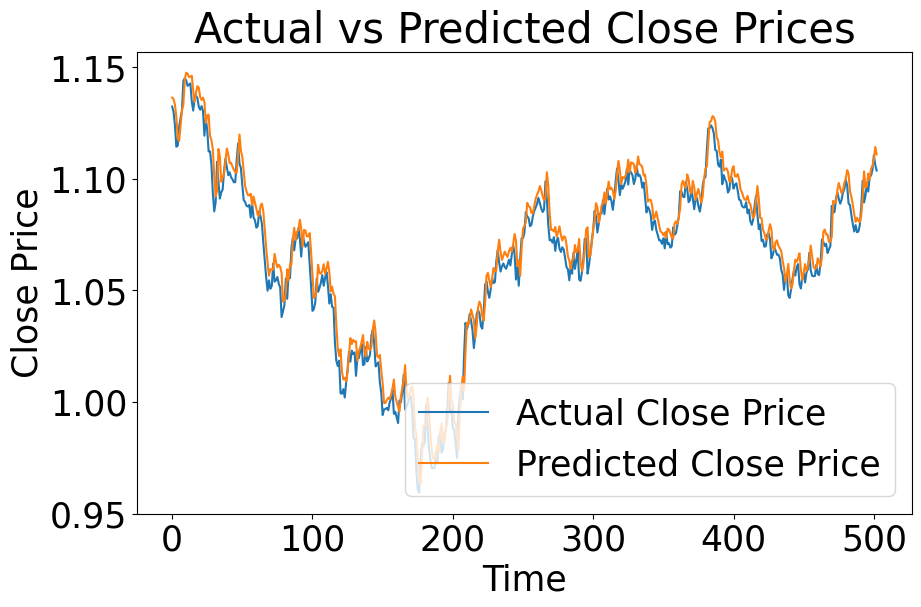

In [ ]:
# Load the data
df=pd.read_csv('Forex_data_feature_added (Garch).csv',index_col='time',parse_dates=True)

# Data Preparation
# The best features based on trial and error
features = ['rsi','volume','close','target']

# Scale the data (Min-Max Scaling)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Define the target variable
target = 'target'

# Create sequences
def create_sequences(data, target_index, time_steps):
    X = []
    y = []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  # Take all features for the past 'time_steps' days
        y.append(data[i, target_index])  # Only take the 'close' price as the target
    return np.array(X), np.array(y)

# Set the time steps
time_steps = 30

# Create sequences for multivariate data
X, y = create_sequences(scaled_data, target_index=features.index(target), time_steps=time_steps)

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM Model
model = Sequential()

# LSTM Layer with Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))

# Output layer (single value prediction for the next close price)
model.add(Dense(units=1))

#Set the learning rate
learning_rate = 0.009

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))

# Make Predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get back to original price scale
predicted_close_price = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), scaled_data.shape[1] - 1)), predictions), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_close_price))
mae = mean_absolute_error(y_test_rescaled, predicted_close_price)
mape=mean_absolute_percentage_error(y_test_rescaled, predicted_close_price)*100
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAE: {mape:.4f}%')
# Plot the Actual vs Predicted Close Prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Close Price')
plt.plot(predicted_close_price, label='Predicted Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4916 - loss: 0.6947 - val_accuracy: 0.4911 - val_loss: 0.6934
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5184 - loss: 0.6919 - val_accuracy: 0.5089 - val_loss: 0.6935
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5343 - loss: 0.6925 - val_accuracy: 0.5089 - val_loss: 0.6933
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5040 - loss: 0.6932 - val_accuracy: 0.5109 - val_loss: 0.6923
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5263 - loss: 0.6932 - val_accuracy: 0.5089 - val_loss: 0.6928
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5302 - loss: 0.6917 - val_accuracy: 0.5050 - val_loss: 0.6925
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5357 - loss: 0.6919 - val_accuracy: 0.5129 - val_loss: 0.6925
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4839 - loss: 0.6935 - val_accuracy: 0.5149 - val_loss: 0.6924


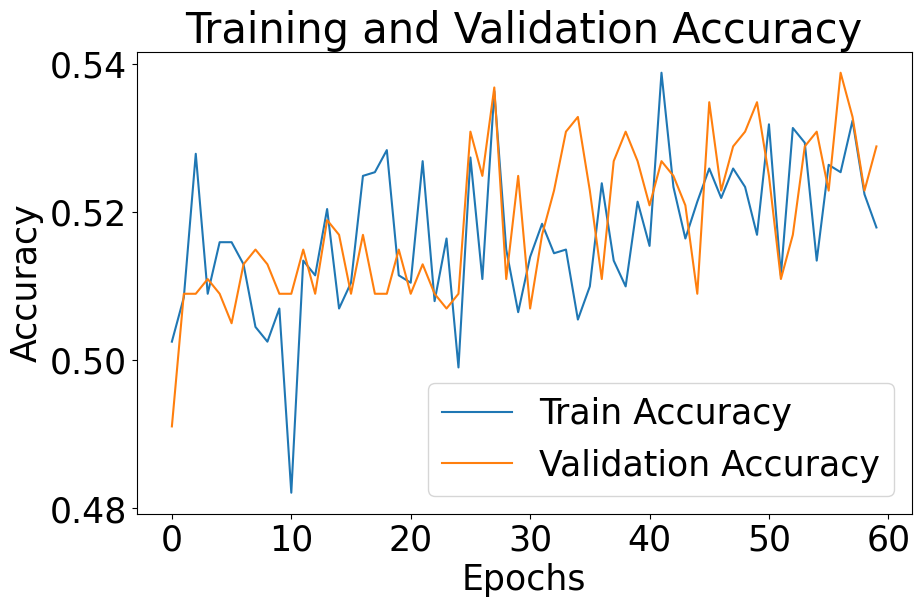

In [ ]:
# Load the data
df=pd.read_csv('Forex_data_feature_added (Garch).csv',index_col='time',parse_dates=True)
# Add binary labels for price movement: 1 if close price goes up, 0 if close price goes down
df['target'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)

# Data Preparation
features = ['rsi', 'volume', 'close']  # Your feature columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Create sequences
def create_sequences(data, target, time_steps=60):
    """
    Create sequences for LSTM input with corresponding binary target labels.
    time_steps: Number of time steps to include in each sequence
    """
    X = []
    y = []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  # Feature sequences
        y.append(target[i])  # Binary target labels
    return np.array(X), np.array(y)

# Define time steps
time_steps = 30

# Create sequences for LSTM model
X, y = create_sequences(scaled_data, df['target'].values, time_steps=time_steps)

# Split into training and testing sets
n_train = int(len(X) * 0.8)  # Use 80% of data for training, 20% for testing
train_X, test_X = X[:n_train], X[n_train:]
train_y, test_y = y[:n_train], y[n_train:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid for binary classification

#Set the learning rate
learning_rate = 0.001

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_X, train_y, epochs=60, batch_size=32, validation_data=(test_X, test_y))

# Make predictions
y_pred = (model.predict(test_X) > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Evaluate the model
accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
